# Table of Contents

1. **Loading the VOC 2007 Dataset**
   - Inspected the structure of the training dataset, including image shape, filename, bounding box coordinates, and labels for detected objects.

2. **Visualizing Label Distributions Across Datasets**
   
3. **Key Takeaways from Label Distribution Analysis**

4. **Visualizing Sample Images with Bounding Boxes**
   - Noted misplaced bounding boxes, requiring repacking of coordinates to xmin, ymin, xmax, ymax.

5. **Observations from Sample Images**
   - Defined the class IDs.

6. **Data Preprocessing and TensorFlow Dataset Creation**

7. **Visualizing Images with Bounding Boxes**

8. **Exploratory Data Analysis (EDA) Phase**
   
9. **Key Takeaways**
   
10. **Augmented Data Generation for Balanced Dataset**
    - Visualized the augmented dataset.

11. **Handling Duplicate Images and Bounding Boxes**

12. **Exploratory Data Analysis (EDA) of Bounding Boxes**

13. **Key Takeaways**
    - Analyzed height and width by class.
    
14. **Bounding Box Area Analysis**
    - Showcased examples of various bounding box aspect ratios.

15. **Save Datasets in Preparation for Modeling**

---

# Summary of Work Done

- The VOC 2007 dataset was loaded and analyzed, focusing on the structure of the training dataset, which included image shapes and bounding box coordinates.
- Label distributions across different datasets were visualized, followed by a summary of key findings.
- Sample images with bounding boxes were visualized, leading to the observation of some misplaced bounding boxes that required correction.
- Class IDs were defined, and data preprocessing steps were taken to create a TensorFlow dataset.
- Exploratory data analysis (EDA) was performed, including an investigation into bounding boxes, aspect ratios, and sizes by class.
- Duplicate images and bounding boxes were handled, ensuring data integrity.
- The augmented dataset was generated and visualized, leading to insights into class distributions and bounding box areas.
- Finally, datasets were saved in preparation for modeling tasks.

In [1]:
# Standard Libraries
import os
import warnings
from collections import Counter, defaultdict

# Data Manipulation and Numerical Operations
import numpy as np
import pandas as pd

# Image Processing
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# TensorFlow and Keras
import tensorflow as tf
import tensorflow_datasets as tfds

# Computer Vision Libraries
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Type Hinting
from typing import Dict, List, Tuple, Optional

# PrettyTable for Displaying Tables
from prettytable import PrettyTable

# Suppress Warnings
warnings.filterwarnings("ignore")

# Suppress TensorFlow Warnings and Information Messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # '0': all logs, '1': filter INFO, '2': filter WARNING, '3': filter ERROR only

# Disable Eager Execution Warning, if Needed
tf.get_logger().setLevel('ERROR')

# Additional Library
import torch
import hashlib

/opt/anaconda3/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Loading the VOC 2007 Dataset

In this section, we are loading the VOC 2007 dataset using TensorFlow Datasets (TFDS). The dataset is split into three parts: training, testing, and validation.

- **Training Data**: This part of the dataset will be used to train our model.
- **Testing Data**: This part will be used to evaluate the performance of our model after training.
- **Validation Data**: This part is used to fine-tune model parameters and prevent overfitting.

The datasets are downloaded from the internet if they are not already available locally, and we are also retrieving metadata about the dataset.

In [2]:
# Load datasets
train_data, info = tfds.load('voc/2007', split='train', download=True, with_info=True)
test_data = tfds.load('voc/2007', download=True, split='test')
validation_data = tfds.load('voc/2007', download=True, split='validation')

# Print dataset info
print(info)


tfds.core.DatasetInfo(
    name='voc',
    full_name='voc/2007/4.0.0',
    description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge,
    corresponding to the Classification and Detection competitions.
    
    In the Classification competition, the goal is to predict the set of labels
    contained in the image, while in the Detection competition the goal is to
    predict the bounding box and label of each individual object.
    annotations.
    """,
    config_description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge
    2007, a.k.a. VOC2007.
    
    A total of 9963 images are included in this dataset, where each image
    contains a set of objects, out of 20 different classes, making a total of
    24640 annotated objects.
    
    """,
    homepage='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/',
    data_dir='/Users/michaelwalker/tensorflow_datasets/voc/2007/4.0.0',
    file_format=tfrecord,
    

The structure of a sample from the training dataset was inspected, revealing the image shape, filename, bounding box coordinates, and corresponding labels for the detected objects.

In [3]:
# Inspect the structure of the train_data
for data in train_data.take(1):  # Take one example from the dataset
    # Print out the structure of the first sample
    print("Image shape:", data['image'].shape)
    print("Filename:", data['image/filename'].numpy().decode('utf-8'))
    print("Bounding Boxes:", data['objects']['bbox'].numpy())
    print("Labels:", data['objects']['label'].numpy())

Image shape: (480, 389, 3)
Filename: 007308.jpg
Bounding Boxes: [[0.14375    0.0437018  0.97083336 0.7763496 ]
 [0.14583333 0.24164525 0.57916665 0.6066838 ]
 [0.6        0.5244216  0.8541667  0.76606685]
 [0.56041664 0.5012854  0.7395833  0.6863753 ]]
Labels: [12 14 12 14]


### Visualizing Label Distributions Across Datasets

In this section, we will:

1. **Count the Number of Object Labels**: A function will be implemented to count how many object labels are present in each image across the training, validation, and test datasets.

2. **Generate Histograms**: We will create histograms to visualize the distribution of the number of objects per image for each dataset. 

These visualizations will provide insights into the dataset structure regarding object density, helping us understand the training environment for our model better.

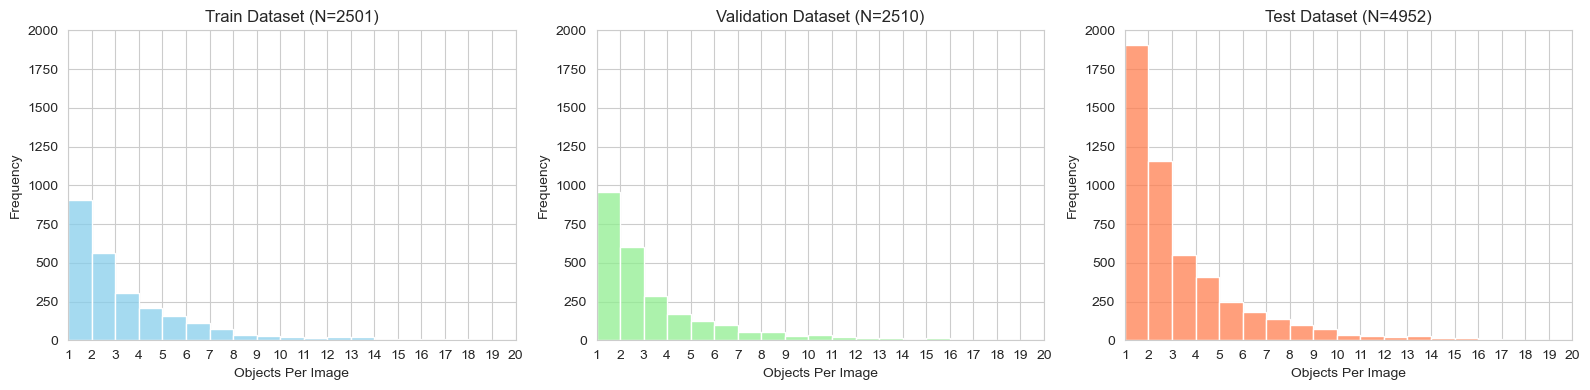

In [4]:

# Function to count labels for all images in the dataset
def count_labels(dataset):
    label_counts = []

    for data in dataset:
        labels = data['objects']['label']
        num_labels = len(labels)
        label_counts.append(num_labels)

    return label_counts

# Get label counts for each dataset
train_label_counts = count_labels(train_data)
val_label_counts = count_labels(validation_data)
test_label_counts = count_labels(test_data)

# Function to plot label distributions with subplots and include N=XYZ in the title
def plot_label_distributions(train_counts, val_counts, test_counts):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))  # 1 row, 3 columns

    # Calculate total counts for N=XYZ
    train_total = len(train_counts)
    val_total = len(val_counts)
    test_total = len(test_counts)

    # Define a range up to 25 for x-axis bins
    max_objects = 20
    bins = range(1, max_objects + 2)  # Bins from 1 to 25

    # Plot for train dataset
    sns.histplot(train_counts, kde=False, bins=bins, color='skyblue', ax=axes[0])
    axes[0].set_title(f'Train Dataset (N={train_total})')
    axes[0].set_xlabel('Objects Per Image')
    axes[0].set_ylabel('Frequency')
    axes[0].set_xticks(range(1, max_objects + 1))  # Set x-ticks up to 25
    axes[0].set_xlim(1, max_objects)  # Limit x-axis to 1 to 25
    axes[0].set_ylim(0, 2000)  # Set y-axis max to 2000

    # Plot for validation dataset
    sns.histplot(val_counts, kde=False, bins=bins, color='lightgreen', ax=axes[1])
    axes[1].set_title(f'Validation Dataset (N={val_total})')
    axes[1].set_xlabel('Objects Per Image')
    axes[1].set_ylabel('Frequency')
    axes[1].set_xticks(range(1, max_objects + 1))  # Set x-ticks up to 25
    axes[1].set_xlim(1, max_objects)  # Limit x-axis to 1 to 25
    axes[1].set_ylim(0, 2000)  # Set y-axis max to 2000

    # Plot for test dataset
    sns.histplot(test_counts, kde=False, bins=bins, color='coral', ax=axes[2])
    axes[2].set_title(f'Test Dataset (N={test_total})')
    axes[2].set_xlabel('Objects Per Image')
    axes[2].set_ylabel('Frequency')
    axes[2].set_xticks(range(1, max_objects + 1))  # Set x-ticks up to 25
    axes[2].set_xlim(1, max_objects)  # Limit x-axis to 1 to 25
    axes[2].set_ylim(0, 2000)  # Set y-axis max to 2000

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot the bar graphs for all datasets in one row
plot_label_distributions(train_label_counts, val_label_counts, test_label_counts)

### Key Takeaways from Label Distribution Analysis

1. **Dataset Size**: The training and validation datasets contain a similar number of samples, approximately 2,500 each, while the test dataset has around 5,000 samples, giving us a larger pool for evaluation.

2. **Object Distribution**: The most common number of objects per image is 1, followed by 2, then 3, and so forth. This indicates a prevalence of images with fewer objects.

3. **Focus on Single Objects**: Since this project primarily deals with single objects in images, our analysis and model development will concentrate on those samples with only one object present.

### Visualizing Sample Images with Bounding Boxes

- In this section we will display a selection of **5 images** from the training dataset, along with their corresponding bounding boxes and labels.
- This visualization will help us verify the annotations and understand the distribution of objects within the images.

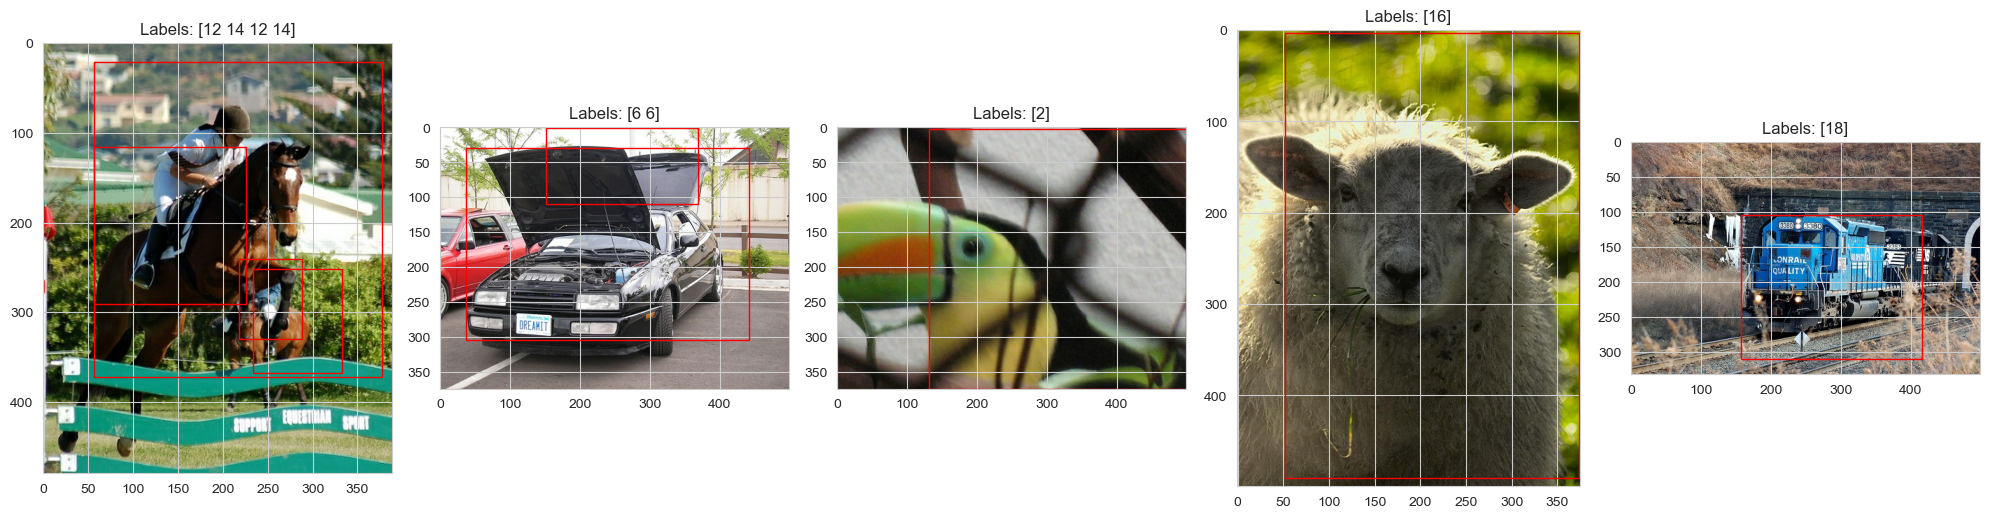

In [5]:
# Define the number of images to display
num_images = 5

# Create a figure with 5 subplots in a single row
fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

# Iterate over the images and axes
for i, (data, ax) in enumerate(zip(train_data.take(num_images), axes)):
    if i >= num_images:
        break

    image = data['image']
    labels = data['objects']['label']
    bboxes = data['objects']['bbox']

    # Convert image tensor to NumPy array
    image_np = image.numpy()

    # Display the image
    ax.imshow(image_np)

    # Get the image dimensions
    img_height, img_width, _ = image_np.shape

    # Draw bounding boxes on the image
    for bbox in bboxes:
        # Convert bounding box coordinates from normalized to pixel values
        xmin, ymin, xmax, ymax = bbox.numpy()
        ymin = ymin * img_height
        xmin = xmin * img_width
        ymax = ymax * img_height
        xmax = xmax * img_width

        # Create a rectangle patch
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=1,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)

    # Display labels and show the plot
    ax.set_title(f'Labels: {labels.numpy()}')
    ax.axis('on')  # Show axis

# Adjust layout
plt.tight_layout()
plt.show()


Note that the bounding boxes appear to be misplaced in several examples. Need to re-pack the 4 coordinates to be xmin, ymin, xmax, ymax

In [6]:
# Define the function to rearrange bounding boxes
def rearrange_bboxes(sample):
    # Extract image, labels, and bounding boxes
    image = sample['image']
    labels = sample['objects']['label']
    bboxes = sample['objects']['bbox']

    # Rearrange bounding boxes from (ymin, xmin, ymax, xmax) to (xmin, ymin, xmax, ymax)
    new_bboxes = tf.stack([
        bboxes[:, 1],  # xmin
        bboxes[:, 0],  # ymin
        bboxes[:, 3],  # xmax
        bboxes[:, 2]   # ymax
    ], axis=1)

    # Create a new sample with rearranged bounding boxes
    return {
        'image': image,
        'objects': {
            'label': labels,
            'bbox': new_bboxes
        }
    }

# Define the function to preprocess the dataset
def preprocess_dataset(dataset):
    return dataset.map(rearrange_bboxes)

# Apply preprocessing to train, validation, and test datasets
train_data_preprocessed = preprocess_dataset(train_data)
validation_data_preprocessed = preprocess_dataset(validation_data)
test_data_preprocessed = preprocess_dataset(test_data)


Show the correctly displayed bounding boxes

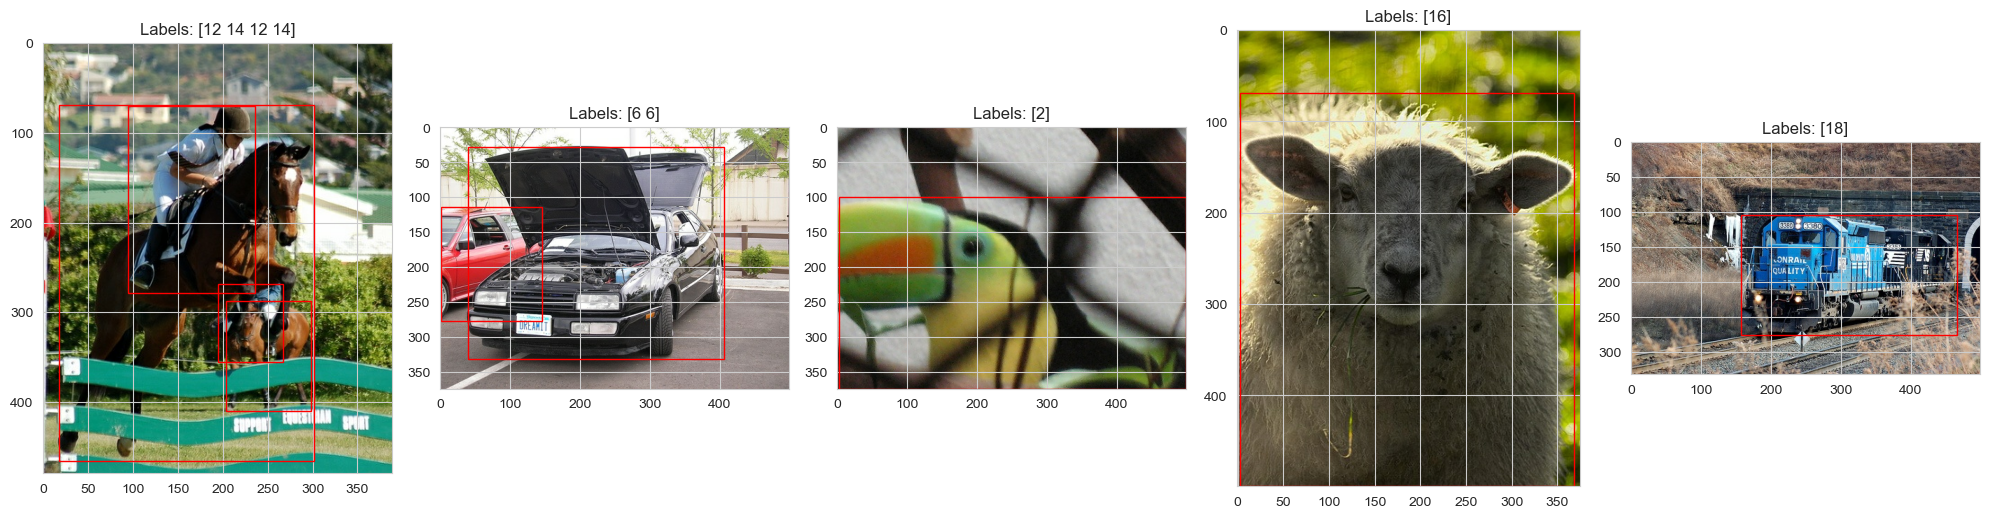

In [7]:

# Define the number of images to display
num_images = 5

# Create a figure with 5 subplots in a single row
fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

# Iterate over the images and axes
for i, (data, ax) in enumerate(zip(train_data_preprocessed.take(num_images), axes)):
    if i >= num_images:
        break

    image = data['image']
    labels = data['objects']['label']
    bboxes = data['objects']['bbox']

    # Convert image tensor to NumPy array
    image_np = image.numpy()

    # Display the image
    ax.imshow(image_np)

    # Get the image dimensions
    img_height, img_width, _ = image_np.shape

    # Draw bounding boxes on the image
    for bbox in bboxes:
        # Convert bounding box coordinates from normalized to pixel values
        xmin, ymin, xmax, ymax = bbox.numpy()
        ymin = ymin * img_height
        xmin = xmin * img_width
        ymax = ymax * img_height
        xmax = xmax * img_width

        # Create a rectangle patch
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=1,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)

    # Display labels and show the plot
    ax.set_title(f'Labels: {labels.numpy()}')
    ax.axis('on')  # Show axis

# Adjust layout
plt.tight_layout()
plt.show()


### Observations from Sample Images

1. The displayed images vary in shape and dimensions, showcasing the diversity within the dataset.
2. Some images contain multiple bounding boxes, indicating the presence of more than one object per image.
3. It is important to define and clarify the labels associated with each bounding box for effective object detection and classification.


In [8]:
def print_dataset_structure(dataset):
    for sample in dataset.take(1):  # Take one sample for inspection
        print("Example data structure:")
        for key, value in sample.items():
            print(f"{key}:")
            if isinstance(value, dict):  # Handle nested dictionaries
                for sub_key, sub_value in value.items():
                    print(f"  {sub_key}: {sub_value.shape}, {sub_value.dtype}")
            else:
                print(f"  {value.shape}, {value.dtype}")

print_dataset_structure(train_data_preprocessed)


Example data structure:
image:
  (480, 389, 3), <dtype: 'uint8'>
objects:
  label: (4,), <dtype: 'int64'>
  bbox: (4, 4), <dtype: 'float32'>


The example data structure reveals that each image has dimensions of 480x389 pixels with 3 color channels, and it contains object labels and corresponding bounding boxes, where each label can represent multiple objects with their respective coordinates in a normalized format.

Define the class ids

In [9]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

### Data Preprocessing and TensorFlow Dataset Creation

In this section, we define a series of functions to preprocess image data and bounding boxes, transforming them into a format suitable for training machine learning models. The following steps are taken:

1. **Bounding Box Scaling**: The `scale_bboxes` function adjusts bounding box coordinates to a new image size while maintaining the aspect ratio.
2. **Bounding Box Clipping**: The `clip_bboxes` function ensures that bounding boxes do not exceed the image dimensions.
3. **Image Formatting**: The `format_image` function resizes images and prepares bounding boxes for model input.
4. **Data Preprocessing**: The `preprocess_data` function processes each image and its corresponding bounding boxes, returning valid samples.
5. **Generator Function**: The `generator` function yields processed samples, converting bounding boxes into TensorFlow tensors.
6. **Creating TensorFlow Dataset**: The `create_tf_dataset` function generates a TensorFlow dataset from the preprocessed data.
7. **Input Conversion**: The `dict_to_tuple` function converts the dataset format to a tuple format for easier model training.

Finally, we create TensorFlow datasets for the training, validation, and test data, mapping them to the appropriate tuple format for use in training our model.

In [10]:

def scale_bboxes(bboxes: List[List[float]], original_size: Tuple[int, int], new_size: int) -> List[List[float]]:
    scale_x = scale_y = new_size / max(original_size)  # Keep aspect ratio square
    return [
        [x_min * scale_x, y_min * scale_y, x_max * scale_x, y_max * scale_y]
        for x_min, y_min, x_max, y_max in bboxes
    ]

def clip_bboxes(bboxes: List[List[float]], image_size: Tuple[int, int]) -> List[List[float]]:
    return [
        [max(0, x_min), max(0, y_min), min(image_size[0], x_max), min(image_size[1], y_max)]
        for x_min, y_min, x_max, y_max in bboxes
        if x_min < x_max and y_min < y_max
    ]

def format_image(img: torch.Tensor, boxes: torch.Tensor, target_size: int) -> Tuple[Optional[np.ndarray], List[List[float]]]:
    image = img.numpy()
    img_height, img_width, _ = image.shape
    bounding_boxes = boxes.numpy() * [img_width, img_height, img_width, img_height]
    valid_bboxes = [b for b in bounding_boxes if b[2] > b[0] and b[3] > b[1]]

    if not valid_bboxes:
        return None, []

    transform = A.Compose([
        A.Resize(height=target_size, width=target_size, p=1),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

    transformed = transform(image=image, bboxes=valid_bboxes, category_ids=np.ones(len(valid_bboxes)))
    resized_image = transformed['image'].permute(1, 2, 0).numpy()
    transformed_bboxes = clip_bboxes(transformed['bboxes'], (target_size, target_size))

    return resized_image, transformed_bboxes

def preprocess_data(data: Dict, target_size: int = 224) -> Optional[Dict]:
    img = data['image']
    boxes = data['objects']['bbox']
    labels = data['objects']['label']

    if len(labels) == 1:
        image, bbox = format_image(img, boxes, target_size)
        if image is not None:
            return {'image': image, 'objects': {'bbox': bbox, 'label': labels}}
    return None

def generator(dataset: List[Dict], target_size: int = 224):
    for data in dataset:
        processed_sample = preprocess_data(data, target_size)
        if processed_sample:
            boxes = tf.convert_to_tensor(processed_sample['objects']['bbox']) if processed_sample['objects']['bbox'] else tf.zeros((0, 4), dtype=tf.float32)
            yield {
                'images': processed_sample['image'],
                'bounding_boxes': {
                    'classes': processed_sample['objects']['label'],
                    'boxes': boxes
                }
            }

def create_tf_dataset(data: List[Dict], target_size: int = 224) -> tf.data.Dataset:
    return tf.data.Dataset.from_generator(
        lambda: generator(data, target_size),
        output_signature={
            'images': tf.TensorSpec(shape=(target_size, target_size, 3), dtype=tf.uint8),
            'bounding_boxes': {
                'classes': tf.TensorSpec(shape=(None,), dtype=tf.int32),
                'boxes': tf.TensorSpec(shape=(None, 4), dtype=tf.float32)
            }
        }
    )

def dict_to_tuple(inputs: Dict) -> Tuple[tf.Tensor, Dict[str, tf.Tensor]]:
    return inputs["images"], {
        'classes': inputs['bounding_boxes']['classes'],
        'boxes': inputs['bounding_boxes']['boxes']
    }

# Example usage
target_size = 224
processed_train_data = create_tf_dataset(train_data_preprocessed, target_size)
processed_val_data = create_tf_dataset(validation_data_preprocessed, target_size)
processed_test_data = create_tf_dataset(test_data_preprocessed, target_size)

train_ds = processed_train_data.map(dict_to_tuple)
val_ds = processed_val_data.map(dict_to_tuple)
test_ds = processed_test_data.map(dict_to_tuple)



## Visualizing Images with Bounding Boxes

This section demonstrates how to visualize a selection of images along with their associated bounding boxes and class labels. The images are displayed in a 5x5 grid, with the following key features:

- **Bounding Boxes**: Each bounding box is drawn in red, indicating the area of interest within the image.
- **Coordinates**: The corner coordinates of each bounding box are displayed in cyan for quick reference.
- **Class Labels**: The class label of the first bounding box in each image is displayed at the top, providing context about the objects detected.
- **Clean Presentation**: Axis labels are removed for a cleaner visualization, focusing solely on the images and bounding boxes.

The example utilizes a subset of 25 samples from the training dataset to showcase these features.


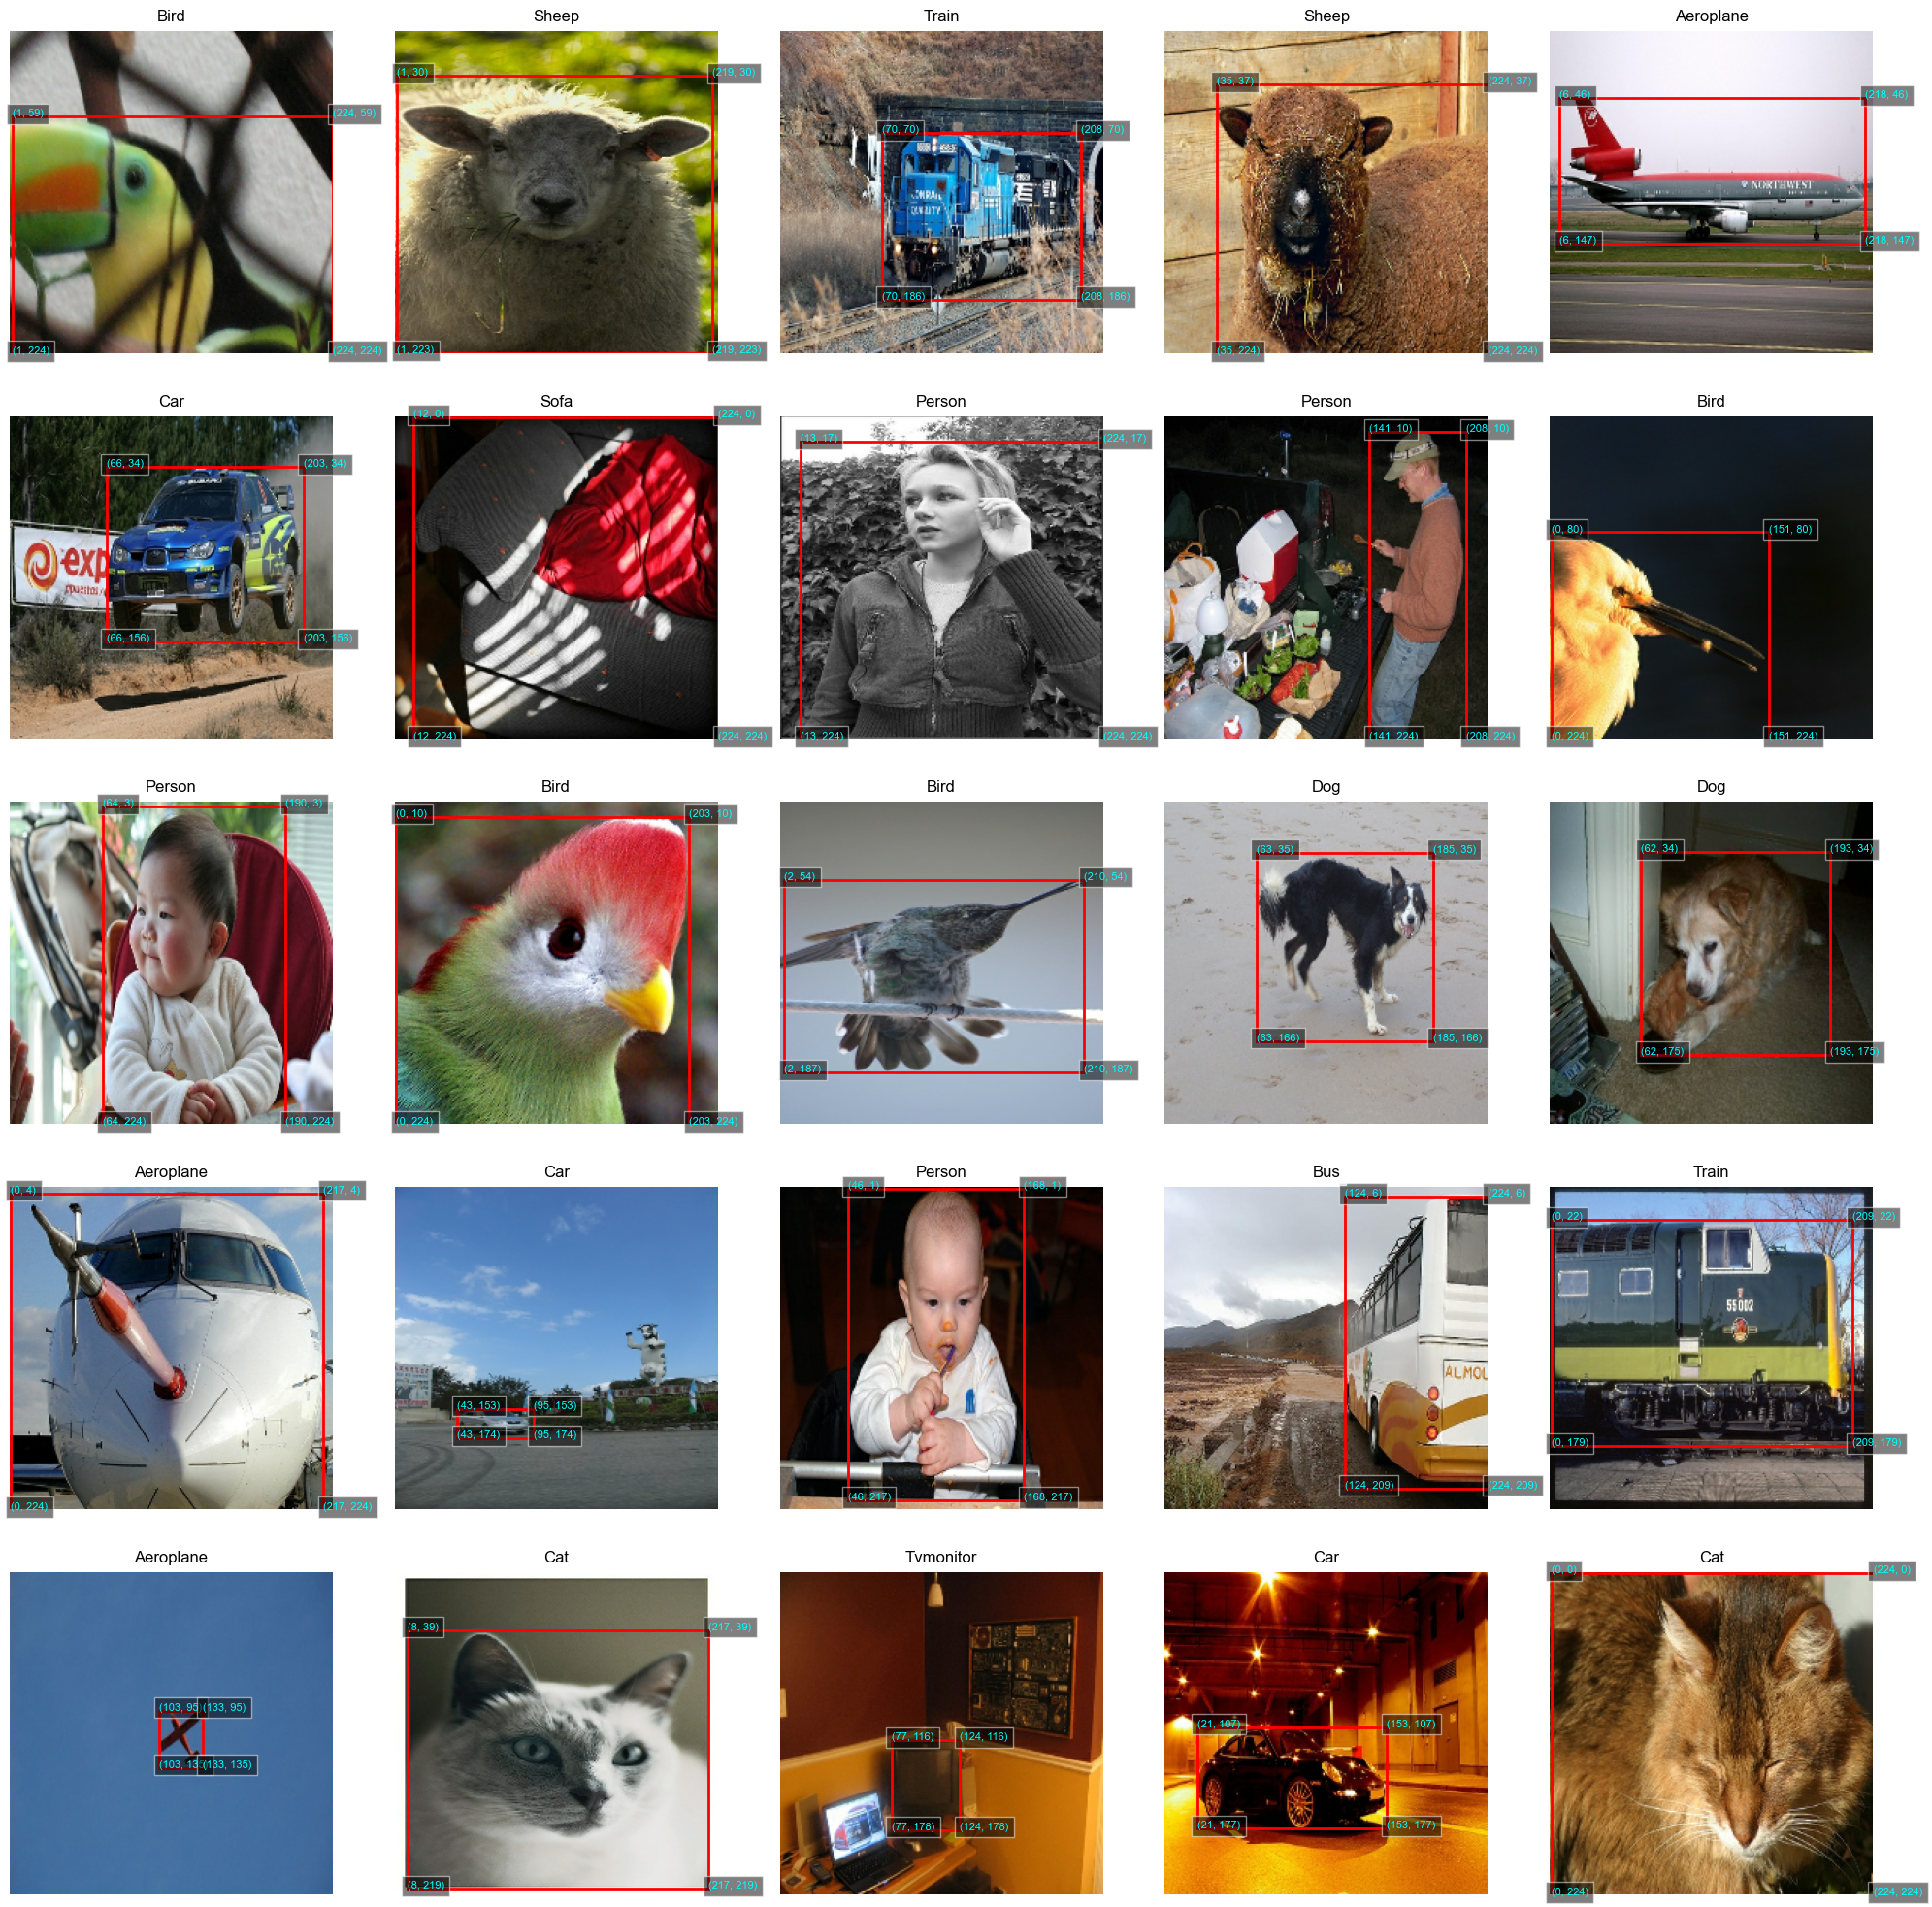

In [11]:

def plot_images_with_bboxes(images: np.ndarray, bboxes_list: np.ndarray, labels_list: np.ndarray, num_images: int = 25):
    # Create a 5x5 grid
    fig, axes = plt.subplots(5, 5, figsize=(20, 20))
    
    for i in range(num_images):
        ax = axes[i // 5, i % 5]
        image = images[i]
        bboxes = bboxes_list[i]
        labels = labels_list[i]
        
        ax.imshow(image)
        
        # Plot bounding boxes
        for bbox, label in zip(bboxes, labels):
            xmin, ymin, xmax, ymax = bbox
            width = xmax - xmin
            height = ymax - ymin
            
            # Draw the bounding box
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            
            # Add text to plot at each corner with no decimals
            ax.text(xmin, ymin, f'({int(xmin)}, {int(ymin)})', color='cyan', fontsize=8, bbox=dict(facecolor='black', alpha=0.5))
            ax.text(xmax, ymin, f'({int(xmax)}, {int(ymin)})', color='cyan', fontsize=8, bbox=dict(facecolor='black', alpha=0.5))
            ax.text(xmin, ymax, f'({int(xmin)}, {int(ymax)})', color='cyan', fontsize=8, bbox=dict(facecolor='black', alpha=0.5))
            ax.text(xmax, ymax, f'({int(xmax)}, {int(ymax)})', color='cyan', fontsize=8, bbox=dict(facecolor='black', alpha=0.5))
        
        # Display the class label on top of the image with a white background and black text
        class_label = class_mapping.get(labels[0], 'Unknown')  # Display the class name for the first bounding box
        ax.text(0.5, 1.02, class_label, color='black', fontsize=12, ha='center', va='bottom', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.7))

        # Remove axis labels for a cleaner display
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage with 25 samples from train_ds
num_samples = 25
images_list = []
bboxes_list = []
labels_list = []

for sample in train_ds.take(num_samples):
    image, bounding_boxes = sample
    bboxes_list.append(bounding_boxes['boxes'].numpy())
    labels_list.append(bounding_boxes['classes'].numpy())
    images_list.append(image.numpy())

# Plot images with bounding boxes and coordinates in a 5x5 grid
plot_images_with_bboxes(np.array(images_list), np.array(bboxes_list), np.array(labels_list), num_images=num_samples)


### Key Items to Notice

- **Image Count**: A total of 25 images are displayed in the grid.
- **Single Object**: Each image contains one object of interest.
- **Bounding Box Details**: Each object is enclosed in a bounding box, represented by four corner coordinates.
- **Class Label**: The label for the object is prominently displayed over each image.
- **Image Size**: All images are resized to a uniform dimension of 224 x 224 pixels for consistency in visualization.

### Exploratory Data Analysis (EDA) Phase

In this section, we focus on understanding the distribution of classes in our dataset. This involves extracting labels from the training, validation, and test datasets, mapping these labels to their respective class names, and counting occurrences of each class. We will also calculate the percentages of each class relative to the total counts, allowing us to visualize the distribution across different datasets.

#### Key Steps in the EDA:

1. **Extract Labels**: Extract the class labels from the dataset.
2. **Map Labels to Names**: Convert numerical labels to their corresponding class names using a mapping.
3. **Count Class Occurrences**: Count how many times each class appears in the datasets.
4. **Calculate Percentages**: Calculate the percentage representation of each class in the dataset.
5. **Visualize Class Distribution**: Plot bar graphs to show both the total occurrences and the percentage distribution of classes across the training, validation, and test datasets.

The following code implements these steps and generates visualizations to aid in our understanding of the dataset's composition.

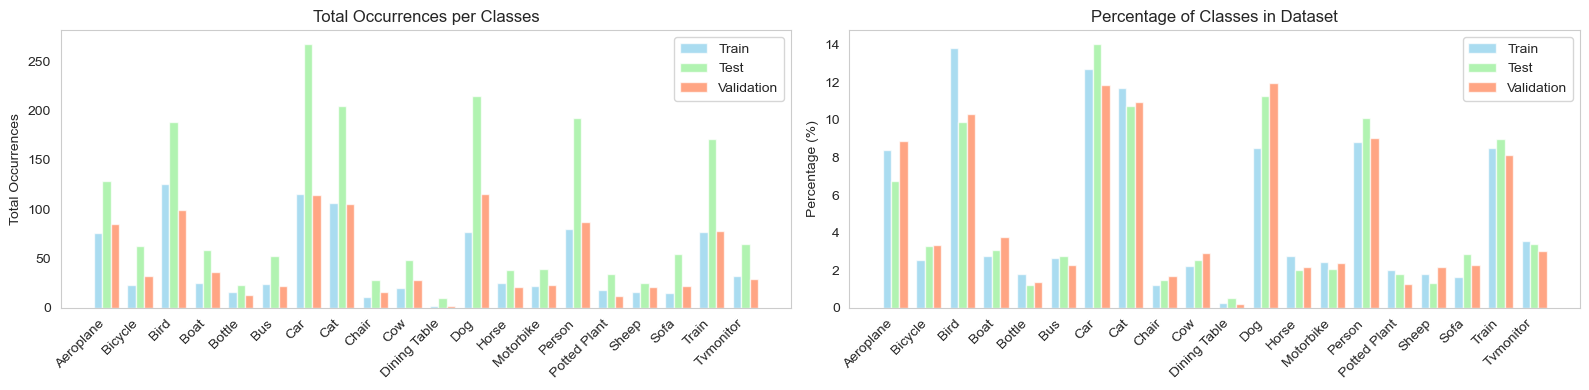

In [12]:

def extract_labels(dataset):
    return [label['classes'].numpy()[0] for _, label in dataset]

def map_labels_to_names(labels, class_mapping):
    return [class_mapping.get(label, 'Unknown') for label  in labels]

def count_class_occurrences(labels):
    return Counter(labels)

def calculate_percentages(class_counts, total_counts):
    return [(class_counts.get(cls, 0) / total_counts) * 100 for cls in class_labels]

def plot_class_distribution(class_labels, train_percentages, test_percentages, val_percentages, 
                             train_totals, test_totals, val_totals):
    x = np.arange(len(class_labels))  # Label locations
    width = 0.25  # Width of the bars

    # Define custom colors
    colors = ['skyblue', 'lightgreen', 'coral']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    # Plot total occurrences (now the first graph)
    ax1.bar(x - width, train_totals, width, label='Train', color=colors[0], alpha=0.7)
    ax1.bar(x, test_totals, width, label='Test', color=colors[1], alpha=0.7)
    ax1.bar(x + width, val_totals, width, label='Validation', color=colors[2], alpha=0.7)
    ax1.set_ylabel('Total Occurrences')
    ax1.set_title('Total Occurrences per Classes')
    ax1.set_xticks(x)
    ax1.set_xticklabels(class_labels, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(False)  # Remove gridlines

    # Plot percentages (now the second graph)
    ax2.bar(x - width, train_percentages, width, label='Train', color=colors[0], alpha=0.7)
    ax2.bar(x, test_percentages, width, label='Test', color=colors[1], alpha=0.7)
    ax2.bar(x + width, val_percentages, width, label='Validation', color=colors[2], alpha=0.7)
    ax2.set_ylabel('Percentage (%)')
    ax2.set_title('Percentage of Classes in Dataset')
    ax2.set_xticks(x)
    ax2.set_xticklabels(class_labels, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(False)  # Remove gridlines

    plt.tight_layout()
    plt.show()

# Extract and map labels
train_labels = extract_labels(train_ds)
test_labels = extract_labels(test_ds)
val_labels = extract_labels(val_ds)

train_labels = map_labels_to_names(train_labels, class_mapping)
test_labels = map_labels_to_names(test_labels, class_mapping)
val_labels = map_labels_to_names(val_labels, class_mapping)

# Count occurrences
train_class_counts = count_class_occurrences(train_labels)
test_class_counts = count_class_occurrences(test_labels)
val_class_counts = count_class_occurrences(val_labels)

# Define class labels
class_labels = sorted(set(train_class_counts) | set(test_class_counts) | set(val_class_counts))

# Calculate total occurrences
total_train = [train_class_counts.get(cls, 0) for cls in class_labels]
total_test = [test_class_counts.get(cls, 0) for cls in class_labels]
total_val = [val_class_counts.get(cls, 0) for cls in class_labels]

# Calculate percentages
train_percentages = calculate_percentages(train_class_counts, sum(total_train))
test_percentages = calculate_percentages(test_class_counts, sum(total_test))
val_percentages = calculate_percentages(val_class_counts, sum(total_val))

# Plot the class distribution with swapped graphs and specified colors
plot_class_distribution(class_labels, train_percentages, test_percentages, val_percentages,
                         total_train, total_test, total_val)

### Key Takeaways

1. **Dataset Sizes**: 
   - The **test dataset** is the largest among the three datasets (train, validation, test), which could influence model evaluation metrics.

2. **Percentage Distribution**: 
   - Percentage-wise, the distribution of classes is **roughly similar** across the training, validation, and test datasets. This suggests that the datasets are balanced in terms of class representation, which is beneficial for model training and evaluation.

3. **Class Imbalance**:
   - There is a notable **class imbalance** in the dataset. Specifically, there are significantly fewer instances of certain classes, such as **dining tables**, while classes like **cars** and **cats** have a much larger representation. This imbalance may affect the model's performance, especially for underrepresented classes, and strategies like data augmentation or class weighting might be needed during training.

Below is a table format to better see specific numbers. Note only 2 examples of Dining Table exist in the training dataset.

In [13]:

# Get class labels and frequencies for each dataset
train_labels = [label['classes'].numpy()[0] for _, label in train_ds]
test_labels = [label['classes'].numpy()[0] for _, label in test_ds]
val_labels = [label['classes'].numpy()[0] for _, label in val_ds]

train_labels = [class_mapping[label] for label in train_labels]
test_labels = [class_mapping[label] for label in test_labels]
val_labels = [class_mapping[label] for label in val_labels]

# Count occurrences of each class
train_class_counts = Counter(train_labels)
test_class_counts = Counter(test_labels)
val_class_counts = Counter(val_labels)

# Extract class labels and their corresponding frequencies
class_labels = sorted(train_class_counts.keys())
train_frequencies = [train_class_counts.get(label, 0) for label in class_labels]
test_frequencies = [test_class_counts.get(label, 0) for label in class_labels]
val_frequencies = [val_class_counts.get(label, 0) for label in class_labels]

# Create a PrettyTable object
table = PrettyTable()
table.field_names = ["Class", "Train Frequency", "Test Frequency", "Validation Frequency"]

# Add rows for each class
for label in class_labels:
    table.add_row([label, train_class_counts.get(label, 0), test_class_counts.get(label, 0), val_class_counts.get(label, 0)])

# Add the total row
totals = [sum(train_frequencies), sum(test_frequencies), sum(val_frequencies)]
table.add_row(["Total"] + totals)

# Print the table
print(table)


+--------------+-----------------+----------------+----------------------+
|    Class     | Train Frequency | Test Frequency | Validation Frequency |
+--------------+-----------------+----------------+----------------------+
|  Aeroplane   |        76       |      129       |          85          |
|   Bicycle    |        23       |       63       |          32          |
|     Bird     |       125       |      188       |          99          |
|     Boat     |        25       |       58       |          36          |
|    Bottle    |        16       |       23       |          13          |
|     Bus      |        24       |       52       |          22          |
|     Car      |       115       |      268       |         114          |
|     Cat      |       106       |      205       |         105          |
|    Chair     |        11       |       28       |          16          |
|     Cow      |        20       |       48       |          28          |
| Dining Table |        2

### Augmented Data Generation for Balanced Dataset

In this section, we will implement data augmentation techniques to create a balanced dataset for training. The augmentation methods will include transformations such as horizontal flips, brightness and contrast adjustments, random rotations, and cropping. 

We will ensure that each class has a minimum number of images (`min_images_per_class`) to mitigate class imbalance in the dataset. The processed data will include both images and their corresponding bounding boxes.

The key functions in this process include:

- **Scaling and Clipping Bounding Boxes**: Functions to adjust bounding box coordinates according to the new image size and to ensure they are within valid image dimensions.
- **Image Augmentation**: A function that applies various augmentations to the images and their bounding boxes.
- **Preprocessing Function**: A function to preprocess individual samples and yield them as a dictionary containing the image and bounding boxes.
- **Dataset Creation**: A generator function that balances the dataset by yielding augmented samples until the desired number of images per class is reached.
- **TensorFlow Dataset Creation**: A function to create a TensorFlow dataset from the generator function.

Let's run the code to generate the augmented and balanced dataset.

In [14]:

# Scale bounding boxes according to new size
def scale_bboxes_augmented(bboxes: List[List[float]], original_size: Tuple[int, int], new_size: int) -> List[List[float]]:
    scale_x = scale_y = new_size / max(original_size)  # Maintain square aspect ratio
    return [[x_min * scale_x, y_min * scale_y, x_max * scale_x, y_max * scale_y] for x_min, y_min, x_max, y_max in bboxes]

# Clip bounding boxes to ensure they remain within image dimensions
def clip_bboxes_augmented(bboxes: List[List[float]], image_size: Tuple[int, int]) -> List[List[float]]:
    return [
        [max(0, x_min), max(0, y_min), min(image_size[0], x_max), min(image_size[1], y_max)]
        for x_min, y_min, x_max, y_max in bboxes
        if x_min < x_max and y_min < y_max
    ]

# Get augmentation transforms
def get_augmentation_transforms(target_size: int, num_augmentations: int = 2):
    augmentations = [
        A.HorizontalFlip(p=1),
        A.RandomBrightnessContrast(p=1),
        A.RandomRotate90(p=1),
        A.RandomSizedCrop(min_max_height=(int(target_size * 0.8), target_size), height=target_size, width=target_size, p=1),
        A.ColorJitter(p=1)
    ]

    num_augmentations = min(num_augmentations, len(augmentations))

    return A.Compose([
        A.Resize(height=target_size, width=target_size, p=1),
        A.OneOf(augmentations, p=1),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

# Format and augment the image
def format_image_augmented(img, boxes, target_size):
    img = np.array(img)
    img_height, img_width, _ = img.shape
    bounding_boxes = boxes * [img_width, img_height, img_width, img_height]
    valid_bboxes = [b for b in bounding_boxes if b[2] > b[0] and b[3] > b[1]]

    if not valid_bboxes:
        return None, []

    transform = get_augmentation_transforms(target_size)
    transformed = transform(image=img, bboxes=valid_bboxes, category_ids=np.ones(len(valid_bboxes)))
    resized_image = transformed['image'].permute(1, 2, 0).numpy()
    transformed_bboxes = clip_bboxes_augmented(transformed['bboxes'], (target_size, target_size))

    return resized_image, transformed_bboxes

# Preprocess data for augmentation
def preprocess_data_augmented(data: Dict, target_size: int = 224) -> Optional[Dict]:
    img = data['image']
    boxes = data['objects']['bbox']
    labels = data['objects']['label']

    if len(labels) == 1:
        image, bbox = format_image_augmented(img, boxes, target_size)
        if image is not None:
            return {'image': image, 'objects': {'bbox': bbox, 'label': labels}}
    return None

# Generator for balanced augmented dataset
def generator_balanced_augmented(dataset: List[Dict], target_size: int = 224, min_images_per_class: int = 10):
    class_counts = Counter()

    for data in dataset:
        processed_sample = preprocess_data_augmented(data, target_size)
        if processed_sample:
            labels = processed_sample['objects']['label']
            image = processed_sample['image']
            bbox = processed_sample['objects']['bbox']
            boxes = tf.convert_to_tensor(bbox) if bbox else tf.zeros((0, 4), dtype=tf.float32)

            # Count occurrences of each label
            for label in labels:
                class_counts[int(label)] += 1

            # Yield the processed data
            yield {
                'images': image,
                'bounding_boxes': {
                    'classes': tf.convert_to_tensor(labels),
                    'boxes': boxes
                }
            }

    # Generate additional samples for classes that fall below the minimum
    for label, count in class_counts.items():
        if count < min_images_per_class:
            additional_needed = min_images_per_class - count

            for _ in range(additional_needed):
                # Yielding a processed sample again for simplicity
                processed_sample = preprocess_data_augmented(data, target_size)  # Modify as needed
                if processed_sample:
                    yield {
                        'images': processed_sample['image'],
                        'bounding_boxes': {
                            'classes': tf.convert_to_tensor([label]),
                            'boxes': tf.convert_to_tensor(processed_sample['objects']['bbox'])
                        }
                    }

# Create TensorFlow dataset
def create_tf_dataset_balanced_augmented(data: List[Dict], target_size: int = 224, min_images_per_class: int = 10) -> tf.data.Dataset:
    balanced_dataset = tf.data.Dataset.from_generator(
        lambda: generator_balanced_augmented(data, target_size, min_images_per_class),
        output_signature={
            'images': tf.TensorSpec(shape=(target_size, target_size, 3), dtype=tf.uint8),
            'bounding_boxes': {
                'classes': tf.TensorSpec(shape=(None,), dtype=tf.int32),
                'boxes': tf.TensorSpec(shape=(None, 4), dtype=tf.float32)
            }
        }
    )

    return balanced_dataset

# Convert dictionary to tuple for TensorFlow processing
def dict_to_tuple(inputs: Dict) -> Tuple[tf.Tensor, Dict[str, tf.Tensor]]:
    return inputs["images"], {
        'classes': inputs['bounding_boxes']['classes'],
        'boxes': inputs['bounding_boxes']['boxes']
    }

# Count the number of elements in the dataset
def count_dataset_elements(dataset: tf.data.Dataset) -> int:
    return sum(1 for _ in dataset)

# Set minimum images per class and create balanced dataset
min_images_per_class = 200  # Desired minimum
train_ds_balanced_augmented = create_tf_dataset_balanced_augmented(train_data_preprocessed, target_size, min_images_per_class)

# Count and display the number of images
num_balanced_augmented_images = count_dataset_elements(train_ds_balanced_augmented)
num_original_images = count_dataset_elements(train_ds)
num_augmented_images = num_balanced_augmented_images - num_original_images

print(f"Number of images in the original dataset: {num_original_images}")
print(f"Number of augmented images required: {num_augmented_images}")
print(f"Number of images in the balanced augmented dataset: {num_balanced_augmented_images}")

# Map the dataset to the appropriate structure
train_ds_balanced_augmented = train_ds_balanced_augmented.map(dict_to_tuple)

Number of images in the original dataset: 905
Number of augmented images required: 3095
Number of images in the balanced augmented dataset: 4000


Observe the frequencies in a table format

In [15]:

# Updated function to extract labels from TensorFlow dataset
def extract_labels_from_dataset(dataset):
    labels = []
    for batch in dataset:
        # Access the correct elements in the tuple
        _, bounding_boxes = batch
        labels.extend(bounding_boxes['classes'].numpy())
    return labels

# Extract labels from each dataset
train_labels = extract_labels_from_dataset(train_ds)
test_labels = extract_labels_from_dataset(test_ds)
val_labels = extract_labels_from_dataset(val_ds)
train_balanced_augmented_labels = extract_labels_from_dataset(train_ds_balanced_augmented)  # Keep this line

# Map the labels to class names
train_labels = [class_mapping[label] for label in train_labels]
test_labels = [class_mapping[label] for label in test_labels]
val_labels = [class_mapping[label] for label in val_labels]
train_balanced_augmented_labels = [class_mapping[label] for label in train_balanced_augmented_labels]  # Keep this line

# Count occurrences of each class
train_class_counts = Counter(train_labels)
test_class_counts = Counter(test_labels)
val_class_counts = Counter(val_labels)
train_balanced_augmented_class_counts = Counter(train_balanced_augmented_labels)  # Keep this line

# Extract class labels and their corresponding frequencies
class_labels = sorted(set(train_class_counts.keys()) | set(test_class_counts.keys()) |
                      set(val_class_counts.keys()) |
                      set(train_balanced_augmented_class_counts.keys()))  # Update this line

train_frequencies = [train_class_counts.get(label, 0) for label in class_labels]
test_frequencies = [test_class_counts.get(label, 0) for label in class_labels]
val_frequencies = [val_class_counts.get(label, 0) for label in class_labels]
train_balanced_augmented_frequencies = [train_balanced_augmented_class_counts.get(label, 0) for label in class_labels]  # Keep this line

# Create a PrettyTable object
table = PrettyTable()
table.field_names = ["Class", "Train Frequency", "Test Frequency", "Validation Frequency", "Train Balanced Augmented Frequency"]  # Updated header

# Add rows for each class
for label in class_labels:
    table.add_row([
        label,
        train_class_counts.get(label, 0),
        test_class_counts.get(label, 0),
        val_class_counts.get(label, 0),
        train_balanced_augmented_class_counts.get(label, 0)  # Keep this line
    ])

# Add the total row
totals = [
    sum(train_frequencies),
    sum(test_frequencies),
    sum(val_frequencies),
    sum(train_balanced_augmented_frequencies)  # Keep this line
]
table.add_row(["Total"] + totals)

# Print the table
print(table)

+--------------+-----------------+----------------+----------------------+------------------------------------+
|    Class     | Train Frequency | Test Frequency | Validation Frequency | Train Balanced Augmented Frequency |
+--------------+-----------------+----------------+----------------------+------------------------------------+
|  Aeroplane   |        76       |      129       |          85          |                200                 |
|   Bicycle    |        23       |       63       |          32          |                200                 |
|     Bird     |       125       |      188       |          99          |                200                 |
|     Boat     |        25       |       58       |          36          |                200                 |
|    Bottle    |        16       |       23       |          13          |                200                 |
|     Bus      |        24       |       52       |          22          |                200           

Now Train Balanced Augmented_ds has 200 of each class, mixed of original + augmented images.

Lets view the augmented dataset

In [ ]:

def plot_images_with_bboxes(images: np.ndarray, bboxes_list: np.ndarray, labels_list: np.ndarray, num_images: int = 25):
    # Create a 5x5 grid
    fig, axes = plt.subplots(5, 5, figsize=(20, 20))

    for i in range(num_images):
        ax = axes[i // 5, i % 5]
        image = images[i]
        bboxes = bboxes_list[i]
        labels = labels_list[i]

        ax.imshow(image)

        # Plot bounding boxes
        for bbox, label in zip(bboxes, labels):
            xmin, ymin, xmax, ymax = bbox
            width = xmax - xmin
            height = ymax - ymin

            # Draw the bounding box
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Add text to plot at each corner with no decimals
            ax.text(xmin, ymin, f'({int(xmin)}, {int(ymin)})', color='cyan', fontsize=8, bbox=dict(facecolor='black', alpha=0.5))
            ax.text(xmax, ymin, f'({int(xmax)}, {int(ymin)})', color='cyan', fontsize=8, bbox=dict(facecolor='black', alpha=0.5))
            ax.text(xmin, ymax, f'({int(xmin)}, {int(ymax)})', color='cyan', fontsize=8, bbox=dict(facecolor='black', alpha=0.5))
            ax.text(xmax, ymax, f'({int(xmax)}, {int(ymax)})', color='cyan', fontsize=8, bbox=dict(facecolor='black', alpha=0.5))

        # Display the class label on top of the image with a white background and black text
        class_label = class_mapping.get(labels[0], 'Unknown')  # Display the class name for the first bounding box
        ax.text(0.5, 1.02, class_label, color='black', fontsize=12, ha='center', va='bottom', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.7))

        # Remove axis labels for a cleaner display
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage with 25 samples from train_ds
num_samples = 25
images_list = []
bboxes_list = []
labels_list = []

for sample in train_ds_balanced_augmented.take(num_samples):
    image, bounding_boxes = sample
    bboxes_list.append(bounding_boxes['boxes'].numpy())
    labels_list.append(bounding_boxes['classes'].numpy())
    images_list.append(image.numpy())

# Plot images with bounding boxes and coordinates in a 5x5 grid
plot_images_with_bboxes(np.array(images_list), np.array(bboxes_list), np.array(labels_list), num_images=num_samples)


Can see that certain images have different colors, orientations, etc:

1. **Horizontal Flip** (`A.HorizontalFlip(p=1)`): Flips the image horizontally. This means the left side of the image becomes the right side and vice versa.
2. **Random Brightness and Contrast** (`A.RandomBrightnessContrast(p=1)`): Randomly adjusts the brightness and contrast of the image. This makes the image lighter or darker and changes the difference between light and dark areas.
3. **Random 90-Degree Rotation** (`A.RandomRotate90(p=1)`): Rotates the image by 90 degrees in a random direction (either clockwise or counterclockwise).
4. **Random Crop and Resize** (`A.RandomSizedCrop(min_max_height=(int(target_size * 0.8), target_size), height=target_size, width=target_size, p=1)`): Randomly crops a section of the image and then resizes it to the target size. The cropped section is at least 80% of the original size but can be as large as the full image.
5. **Color Jitter** (`A.ColorJitter(p=1)`): Randomly alters the image’s color properties, such as brightness, contrast, saturation, and hue, to create different visual effects.

### Handling Duplicate Images and Bounding Boxes

1. **Detecting Duplicates**:
    - Uses a hash function to find and report duplicate images.

2. **Counting Bounding Boxes**:
    - Counts how many images have bounding boxes and how many don't.

3. **Filtering Images**:
    - Removes images without bounding boxes from the dataset.

#### Example Usage:
- Detect duplicates: `check_for_duplicates(train_ds_balanced_augmented)`
- Count bounding boxes: `count_images_with_and_without_boxes(train_ds_balanced_augmented)`
- Filter images: `train_ds_balanced_augmented = train_ds_balanced_augmented.filter(filter_fn)`

In [ ]:
def compute_image_hash(image: np.ndarray) -> str:
    """Compute a SHA-256 hash for the given image."""
    image_bytes = image.tobytes()  # Convert image to bytes
    hash_object = hashlib.sha256(image_bytes)  # Compute SHA-256 hash
    return hash_object.hexdigest()

def check_for_duplicates(dataset: tf.data.Dataset) -> None:
    """Check for duplicate images in the dataset."""
    seen_hashes = set()
    duplicates = set()
    
    for sample in dataset:
        image, _ = sample  # Unpack the tuple
        image = image.numpy()  # Convert tensor to numpy array
        image_hash = compute_image_hash(image)  # Compute image hash
        
        if image_hash in seen_hashes:
            duplicates.add(image_hash)  # Add to duplicates if already seen
        else:
            seen_hashes.add(image_hash)  # Add to seen hashes
    
    if duplicates:
        print(f"Found {len(duplicates)} duplicate images.")
    else:
        print("No duplicate images found.")

# Check for duplicate images in the balanced augmented dataset
check_for_duplicates(train_ds_balanced_augmented)

def count_images_with_and_without_boxes(dataset: tf.data.Dataset) -> None:
    """Count images with and without bounding boxes in the dataset."""
    count_with_boxes = 0
    count_without_boxes = 0

    for sample in dataset:
        image, labels = sample  # Unpack the tuple
        boxes = labels['boxes']  # Retrieve bounding boxes

        if tf.shape(boxes)[0] > 0:
            count_with_boxes += 1  # Increment count if boxes exist
        else:
            count_without_boxes += 1  # Increment count if no boxes

    print(f"Number of images with bounding boxes: {count_with_boxes}")
    print(f"Number of images without bounding boxes: {count_without_boxes}")

# Count images with and without bounding boxes in the dataset
count_images_with_and_without_boxes(train_ds_balanced_augmented)

def filter_fn(image, labels):
    """Filter function to retain images with bounding boxes."""
    boxes = labels['boxes']  # Retrieve bounding boxes
    return tf.shape(boxes)[0] > 0  # Keep images with at least one bounding box

# Apply the filter to remove images without bounding boxes
train_ds_balanced_augmented = train_ds_balanced_augmented.filter(filter_fn)

# Verify the dataset after filtering
count_images_with_and_without_boxes(train_ds_balanced_augmented)

### Exploratory Data Analysis (EDA) of Bounding Boxes

In this section, we analyze the bounding boxes from the dataset to gain insights into their aspect ratios, dimensions, and how they vary across different object classes.

1. **Bounding Box Aspect Ratios and Dimensions**:
    - We compute the aspect ratios (width/height) of bounding boxes, as well as the width and height distributions.
    
2. **Aspect Ratios by Object Class**:
    - We examine the average aspect ratio for each class to understand how object shapes differ across categories.
    
3. **Visualization**:
    - We present three visualizations to summarize our findings:
        - **Aspect Ratio Distribution**: A histogram showing the frequency of different aspect ratios.
        - **Bounding Box Width vs Height**: A scatter plot showing the relationship between width and height, with a line of best fit.
        - **Average Aspect Ratio by Class**: A bar chart showing the average aspect ratio for each class.

In [ ]:

# Class IDs
class_ids = [
    "Aeroplane", "Bicycle", "Bird", "Boat", "Bottle", "Bus", "Car",
    "Cat", "Chair", "Cow", "Dining Table", "Dog", "Horse", "Motorbike",
    "Person", "Potted Plant", "Sheep", "Sofa", "Train", "Tvmonitor"
]

# Function to analyze bounding box aspect ratios and dimensions
def analyze_bounding_boxes(dataset):
    aspect_ratios = []
    widths = []
    heights = []

    for batch in dataset:
        _, annotations = batch
        bboxes = annotations['boxes'].numpy()  # Extract bounding boxes

        for bbox in bboxes:  # Each bbox is in the format [xmin, ymin, xmax, ymax]
            xmin, ymin, xmax, ymax = bbox
            height = ymax - ymin
            width = xmax - xmin

            if height > 0:
                aspect_ratios.append(width / height)
                widths.append(width)
                heights.append(height)

    return aspect_ratios, widths, heights

# Function to analyze bounding box aspect ratios by class
def analyze_bounding_box_aspect_ratios_by_class(dataset):
    class_aspect_ratios = defaultdict(list)

    for batch in dataset:
        _, annotations = batch
        bboxes = annotations['boxes'].numpy()
        labels = annotations['classes'].numpy()

        for bbox, label in zip(bboxes, labels):
            xmin, ymin, xmax, ymax = bbox
            height = ymax - ymin
            width = xmax - xmin

            if height > 0:
                class_aspect_ratios[label].append(width / height)

    average_aspect_ratios = {
        label: np.mean(aspect_ratios)
        for label, aspect_ratios in class_aspect_ratios.items()
    }

    for class_label in range(len(class_ids)):
        average_aspect_ratios.setdefault(class_label, np.nan)

    return average_aspect_ratios

# Perform analyses on train_ds
bounding_box_aspect_ratios, widths, heights = analyze_bounding_boxes(train_ds)
average_aspect_ratios = analyze_bounding_box_aspect_ratios_by_class(train_ds)

# Prepare data for plots
aspect_ratios = [average_aspect_ratios.get(i, np.nan) for i in range(len(class_ids))]

# Create a 1-row by 3-column grid for the plots
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Set Seaborn style
sns.set(style="whitegrid")

# Plot Aspect Ratio Distribution of Bounding Boxes
axs[0].hist(bounding_box_aspect_ratios, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axs[0].set_title('Bounding Box Aspect Ratio Distribution')
axs[0].set_xlabel('Aspect Ratio (Width/Height)')
axs[0].set_ylabel('Frequency')

# Plot Bounding Box Width vs Height
axs[1].scatter(widths, heights, alpha=0.5, color='lightgreen')
axs[1].set_title('Bounding Box Width vs Height')
axs[1].set_xlabel('Width')
axs[1].set_ylabel('Height')

# Fit line of best fit
if widths and heights:  # Ensure there is data
    coeffs = np.polyfit(widths, heights, 1)  # 1st degree polynomial (linear)
    fit_line = np.polyval(coeffs, widths)  # Calculate the y-values for the fit line
    axs[1].plot(widths, fit_line, color='green', linewidth=2, label='Line of Best Fit')
    axs[1].legend()

axs[1].set_xlim(0, max(widths) * 1.1 if widths else 1)  # Handle empty case
axs[1].set_ylim(0, max(heights) * 1.1 if heights else 1)  # Handle empty case
axs[1].grid(True)

# Plot Average Aspect Ratio by Class
axs[2].bar(class_ids, aspect_ratios, color='coral', alpha=0.7, edgecolor='black')
axs[2].set_title('Average Aspect Ratio by Class')
axs[2].set_xlabel('Class')
axs[2].set_ylabel('Average Aspect Ratio (Width/Height)')
axs[2].set_xticklabels(class_ids, rotation=45)  # Rotate class labels for better readability
axs[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Key Takeaways:

1. **Aspect Ratio of 1:1 is Most Common**:
    - The most frequent aspect ratio is close to 1, meaning that square bounding boxes are common in the dataset.
    
2. **Width and Height Correlation**:
    - In general, as the width of bounding boxes increases, the height tends to increase proportionally, indicating consistent object scaling.

3. **Class-Specific Aspect Ratios**:
    - Different classes exhibit typical aspect ratios. For instance:
        - **Bottles**: Tend to have a tall, narrow shape.
        - **Aeroplanes**: Typically have a wide aspect ratio.

Dive deeper in to Height and Width by Class

In [ ]:

# Function to create a DataFrame for bounding boxes
def create_bounding_box_dataframe(dataset):
    data = []

    for batch in dataset:
        _, annotations = batch
        bboxes = annotations['boxes'].numpy()
        labels = annotations['classes'].numpy()

        for bbox, label in zip(bboxes, labels):
            xmin, ymin, xmax, ymax = bbox
            height = ymax - ymin
            width = xmax - xmin
            data.append({'Class': label, 'Height': height, 'Width': width})

    return pd.DataFrame(data)

# Create the DataFrame
data = create_bounding_box_dataframe(train_ds)

# Calculate average height and width by class
average_heights = [np.mean(data[data['Class'] == class_id]['Height']) for class_id in range(len(class_ids))]
average_widths = [np.mean(data[data['Class'] == class_id]['Width']) for class_id in range(len(class_ids))]

# Prepare aspect ratios, ensuring we handle NaN values appropriately
aspect_ratios = [average_aspect_ratios.get(i, np.nan) for i in range(len(class_ids))]

# Create a 1-row by 3-column grid for the average plots
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Set Seaborn style
sns.set(style="whitegrid")

# Plot Average Height by Class
axs[0].bar(class_ids, average_heights, color='skyblue', alpha=0.7, edgecolor='black')
axs[0].set_title('Average Height by Class')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Average Height')
axs[0].set_xticklabels(class_ids, rotation=45)

# Plot Average Width by Class
axs[1].bar(class_ids, average_widths, color='lightgreen', alpha=0.7, edgecolor='black')
axs[1].set_title('Average Width by Class')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Average Width')
axs[1].set_xticklabels(class_ids, rotation=45)

# Plot Average Aspect Ratio by Class
axs[2].bar(class_ids, aspect_ratios, color='coral', alpha=0.7, edgecolor='black')
axs[2].set_title('Average Aspect Ratio by Class')
axs[2].set_xlabel('Class')
axs[2].set_ylabel('Average Aspect Ratio (Width/Height)')
axs[2].set_xticklabels(class_ids, rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

Similar to before we see certain classes associated with being taller or wider

**Bounding Box Area Analysis:**  
  - Computed bounding box areas for each object class.
  - Generated a box plot showing area distributions across classes.
  - Visualized the variability in object sizes for different classes.

In [ ]:
# Class IDs
class_ids = [
    "Aeroplane", "Bicycle", "Bird", "Boat", "Bottle", "Bus", "Car",
    "Cat", "Chair", "Cow", "Dining Table", "Dog", "Horse", "Motorbike",
    "Person", "Potted Plant", "Sheep", "Sofa", "Train", "Tvmonitor"
]

# Function to analyze bounding boxes and compute area
def analyze_bounding_boxes_area(dataset):
    class_areas = defaultdict(list)

    for batch in dataset:
        _, annotations = batch
        bboxes = annotations['boxes'].numpy()  # Extract bounding boxes
        labels = annotations['classes'].numpy()  # Extract class labels

        for bbox, label in zip(bboxes, labels):
            xmin, ymin, xmax, ymax = bbox
            height = ymax - ymin
            width = xmax - xmin
            area = width * height

            if area > 0:
                class_areas[label].append(area)

    return class_areas

# Perform analysis on the dataset
class_areas = analyze_bounding_boxes_area(train_ds)

# Prepare data for plotting
areas = [class_areas[i] for i in range(len(class_ids))]

# Create a box plot for Bounding Box Area vs Class
plt.figure(figsize=(14, 6))
sns.boxplot(data=areas)
plt.title('Bounding Box Area by Class')
plt.ylabel('Bounding Box Area (px²)')  # Added px² to the y-axis label
plt.xticks(ticks=range(len(class_ids)), labels=class_ids, rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Next we show examples of various bounding box aspect ratios

In [ ]:
def plot_images_with_bboxes(images_data: list):
    """Plot images with bounding boxes and aspect ratio annotations."""
    num_images = len(images_data)

    # Create a figure with 2 rows and 3 columns
    rows, cols = 2, 3
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 8, rows * 6))  # Adjusted size for better spacing

    for i in range(num_images):
        ax = axes[i // cols, i % cols]  # Get the appropriate subplot

        image, bboxes, labels, aspect_ratio = images_data[i]
        ax.imshow(image)

        for bbox, label in zip(bboxes, labels):
            xmin, ymin, xmax, ymax = bbox  # Extract bounding box coordinates
            width, height = xmax - xmin, ymax - ymin

            # Draw the bounding box
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Annotate the corners of the bounding box
            for (x, y) in [(xmin, ymin), (xmax, ymin), (xmin, ymax), (xmax, ymax)]:
                ax.text(x, y, f'({int(x)}, {int(y)})', color='cyan', fontsize=12,
                        bbox=dict(facecolor='black', alpha=0.5))

        # Display the aspect ratio at the top of the image
        aspect_ratio_text = f'Aspect Ratio: {aspect_ratio:.2f}'
        ax.text(0.5, 1.02, aspect_ratio_text, color='black', fontsize=12,
                ha='center', va='bottom', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0))

        # Display the class label at the top
        class_label = class_mapping.get(labels[0], 'Unknown')
        ax.text(0.5, 1.05, class_label, color='black', fontsize=12,
                ha='center', va='bottom', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0))
        
        ax.axis('off')  # Hide axis ticks

    # Hide any unused subplots
    for j in range(num_images, rows * cols):
        axes[j // cols, j % cols].axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Show all images in a 2x3 grid

# Collect images for specified aspect ratios with a tolerance
aspect_ratios = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]  # Aspect ratios to target
images_data = []

# Initialize a dictionary to track found images for each aspect ratio
found_images = {ratio: None for ratio in aspect_ratios}
tolerance = 0.05  # Allowable deviation from target aspect ratios

for sample in train_ds:
    image, bounding_boxes = sample
    bboxes = bounding_boxes['boxes'].numpy()  # Convert bounding boxes to numpy array
    labels = bounding_boxes['classes'].numpy()  # Convert labels to numpy array

    for bbox, label in zip(bboxes, labels):
        xmin, ymin, xmax, ymax = bbox  # Extract bounding box coordinates
        width, height = xmax - xmin, ymax - ymin
        aspect_ratio = width / height  # Calculate aspect ratio

        # Check for each specified aspect ratio within tolerance
        for ratio in aspect_ratios:
            if (ratio - tolerance) <= aspect_ratio <= (ratio + tolerance) and found_images[ratio] is None:
                images_data.append((image.numpy(), [bbox], [label], aspect_ratio))  # Store image data
                found_images[ratio] = True  # Mark this ratio as found
                break  # Exit the loop after finding one match

# Sort images_data based on the aspect ratios (in ascending order)
images_data.sort(key=lambda x: x[3])  # Sort by the fourth element (aspect ratio)

# Convert lists to arrays and plot
if images_data:
    plot_images_with_bboxes(images_data)
else:
    print("No images found for the specified aspect ratios.")

Save datasets in preparation for modeling

In [ ]:
# Create the /datasets folder if it doesn't exist
output_dir = './datasets'
os.makedirs(output_dir, exist_ok=True)

def serialize_example(image, classes, boxes):
    """Create a tf.train.Example from image, classes, and bounding boxes."""
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image).numpy()])),
        'classes': tf.train.Feature(int64_list=tf.train.Int64List(value=classes.numpy().flatten().tolist())),  # Convert to NumPy
        'boxes': tf.train.Feature(float_list=tf.train.FloatList(value=boxes.numpy().flatten().tolist())),  # Convert to NumPy
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def save_tf_dataset(dataset: tf.data.Dataset, file_path: str):
    """Save the dataset as a TFRecord file."""
    with tf.io.TFRecordWriter(file_path) as writer:
        for image, bbox in dataset:
            tf_example = serialize_example(image, bbox['classes'], bbox['boxes'])
            writer.write(tf_example.SerializeToString())

# Save train, val, test, and augmented datasets into the /datasets folder
save_tf_dataset(train_ds, os.path.join(output_dir, 'train_ds.tfrecord'))
save_tf_dataset(val_ds, os.path.join(output_dir, 'val_ds.tfrecord'))
save_tf_dataset(test_ds, os.path.join(output_dir, 'test_ds.tfrecord'))
save_tf_dataset(train_ds_balanced_augmented, os.path.join(output_dir, 'train_ds_balanced_augmented.tfrecord'))

print("Datasets saved successfully in /datasets folder")
